In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# k-nearest neighbors

This dataset was obtained from https://archive.ics.uci.edu/ml/datasets/Heart+Disease (this is a great resource for datasets to try machine learning on). It has data on patients that are and are not diagnosed with heart disease.

The attributes are:
* age: age in years 
* sex: sex (1 = male; 0 = female) 
* cp: chest pain type 
 * -- Value 1: typical angina 
 * -- Value 2: atypical angina 
 * -- Value 3: non-anginal pain 
 * -- Value 4: asymptomatic 
* trestbps: resting blood pressure (in mm Hg on admission to the hospital) 
* chol: serum cholestoral in mg/dl 
* fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) 
* restecg: resting electrocardiographic results 
 * -- Value 0: normal 
 * -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) 
 * -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria 
* thalach: maximum heart rate achieved 
* exang: exercise induced angina (1 = yes; 0 = no) 
* oldpeak = ST depression induced by exercise relative to rest 
* slope: the slope of the peak exercise ST segment 
 * -- Value 1: upsloping 
 * -- Value 2: flat 
 * -- Value 3: downsloping 
* ca: number of major vessels (0-3) colored by flourosopy 
* thal: 3 = normal; 6 = fixed defect; 7 = reversable defect 
* num: diagnosis of heart disease (angiographic disease status) 
 * -- Value 0: absence.
 * -- Value 1,2,3,4: presence of heart disease


# Explore the data

Read in the data, modify the dependent variable name and plot a histogram of the ages of patients, both healthy and those with heart disease.

In [2]:
# Comma-separated values
df = pd.read_csv('adult.data')

# Rename 'num' column to 'disease' and change 1,2,3,4 to 1
# df = df.rename({'num':'disease'}, axis=1)
# df['disease'] = df.disease.apply(lambda x: min(x, 1))

df = df.drop(['education'], axis=1)
df = df.drop(['workclass'], axis=1)
df = df.drop(['fnlwgt'], axis=1)
df = df.drop(['marital-status'], axis=1)
df = df.drop(['occupation'], axis=1)
df = df.drop(['relationship'], axis=1)
df = df.drop(['race'], axis=1)
df = df.drop(['capital-gain'], axis=1)
df = df.drop(['capital-loss'], axis=1)
df = df.drop(['native-country'], axis=1)
df = df.drop(['income'], axis=1) # this column was unfortunately two values, larger or smaller than 50K
# df = df[~df.native-country.str.contains("?")]
display(df.head(40))

male = df[df.sex == 'Male'].count().sex
female = df[df.sex == 'Female'].count().sex
print('Male: {}\nFemale: {}'.format(male, female))
mtof = male/female
print(mtof)

cols_to_norm = ['age', 'education-num', 'hours-per-week']
df[cols_to_norm] = StandardScaler().fit_transform(df[cols_to_norm])
display(df.head(5))

,age,education-num,sex,hours-per-week
0,39,13,Male,40
1,50,13,Male,13
2,38,9,Male,40
3,53,7,Male,40
4,28,13,Female,40
5,37,14,Female,40
6,49,5,Female,16
7,52,9,Male,45
8,31,14,Female,50
9,42,13,Male,40


Male: 21790
Female: 10771
2.0230247887846997


,age,education-num,sex,hours-per-week
0,0.030671,1.134739,Male,-0.035429
1,0.837109,1.134739,Male,-2.222153
2,-0.042642,-0.420060,Male,-0.035429
3,1.057047,-1.197459,Male,-0.035429
4,-0.775768,1.134739,Female,-0.035429


# k-nearest neighbors - first try

Try it first on age, using the scikit-learn package. This code simply looks for the five patients with ages closest to a given age, then prints how many of those patients are healthy and how many have heart disease.

In [3]:
# Use knn on age. First create a nearest neighbors object.
nn = NearestNeighbors(n_neighbors=10, metric='euclidean', algorithm='auto')

# Create a two-dimensional array. This is basically a one-dimensional array with
# single-element arrays of patient ages in the second dimension. We're going to
# search for neighbors using only the age dimension.
X = [[x] for x in df.age]

# This builds an index data structure under the hood for query performance
fit = nn.fit(X)

# Find the k nearest neighbors
distances, indices = fit.kneighbors([[70]])
display(indices[0])

# Get the patients that are near the age
nbrs = df.iloc[indices[0]]
display(nbrs)

# Print how many patients are sick and how many are healthy
male = nbrs[nbrs.sex == 'Male'].count().sex
female = nbrs[nbrs.sex == 'Female'].count().sex
print('Male: {}\nFemale: {}'.format(male, female))


array([32277, 11996, 18277, 31696, 18413,  5272, 19212,  1040, 24238,
        5406], dtype=int64)

,age,education-num,sex,hours-per-week
32277,3.769612,-0.420060,Female,-1.250276
11996,3.769612,1.134739,Male,1.179417
18277,3.769612,1.134739,Male,-1.655225
31696,3.769612,-0.420060,Male,-0.035429
18413,3.769612,1.134739,Female,-2.465122
5272,3.769612,-1.974858,Female,-0.035429
19212,3.769612,-0.031360,Female,-0.278399
1040,3.769612,-0.420060,Female,-0.035429
24238,3.769612,-3.140957,Female,-0.035429
5406,3.769612,1.523438,Male,0.774468


Male: 4
Female: 6


# multiple dimensions

Now run knn on a patient from the database using an additional dimension, or attribute: trestbps (resting blood pressure).

In [4]:
# df[['age', 'trestbps']].values
X = df[['age', 'education-num', 'hours-per-week']].values
y = df[['sex']].values
i = random.randint(0,len(X)-1)

def predict(X, y, df, i, k): 
    nn = NearestNeighbors(n_neighbors=k, metric='euclidean', algorithm='auto')
    # This builds an index data structure under the hood for query performance
    fit = nn.fit(X)
    patientX = X[i]
    patienty = y[i]
    # display(df.iloc[i])

    # Find the k nearest neighbors to the patient. Problem: the patient
    # itself will be found in the list of neighbors!
    distances, indices = fit.kneighbors([patientX])
    nbrs = df.iloc[indices[0]]
    # display(nbrs)

    male = nbrs[nbrs.sex == 'Male'].count().sex
    female = nbrs[nbrs.sex == 'Female'].count().sex
    # print('Male: {}\nFemale: {}'.format(male, female))
    predict = 'Female' if (female * mtof > male) else 'Male'
    actual = 'Female' if (patienty == 'Female') else 'Male'
    success = predict == actual
    # print(success)
    return predict

display(df.iloc[i])

display(predict(X, y, df, i, 10))

age                -1.06902
education-num      -0.42006
sex                  Female
hours-per-week   -0.0354294
Name: 30949, dtype: object

'Female'

# multiple tests

In [5]:
X = df[['age', 'education-num']].values
y = df[['sex']].values

# This builds an index data structure under the hood for query performance
fit = nn.fit(X)

# Get random patients to test on
n = 7
pindices = [random.randint(0,len(X)-1) for _ in range(n)]
patientsX = X[pindices]
patientsy = y[pindices]

# Find the k nearest neighbors to the patient. Problem: we still
# have the problem of the patient itself being found!
distances, indices = fit.kneighbors(patientsX)
print('indices of k-nearest neighbors for each patient:')
display(indices)

for i in range(n):
    print('nearest neighbors to patient: {}:'.format(patientsX[i]))
    nbrs = df.iloc[indices[i]]
    display(nbrs)

# This is where we would compile how many patients are predicted
# correctly.

indices of k-nearest neighbors for each patient:


array([[14196,  6836, 13755, 21777,  9284, 20443,    73,   730,  4993,
        21507],
       [20615, 31310, 30204,  2034, 27455, 18309, 15778,  9025,  2640,
        26790],
       [ 9515, 22110, 20892, 22374, 20409, 22375, 13283, 22049, 21354,
        21642],
       [11376,  9364, 27995, 10338, 31711, 16905, 24926, 14230,  7510,
        29634],
       [13403, 20677,  8916, 12773, 12760, 22308,  6849,  2813, 13135,
        21299],
       [17084,  1742, 23207,  7626, 13911, 27164, 30670, 13037, 25275,
          289],
       [11871, 26600,  5641, 20617, 26274, 17589,  5693,  3503, 11772,
        11901]], dtype=int64)

nearest neighbors to patient: [-1.14233079 -0.03136003]:


,age,education-num,sex,hours-per-week
14196,-1.142331,-0.03136,Male,-0.035429
6836,-1.142331,-0.03136,Male,-0.845327
13755,-1.142331,-0.03136,Female,-0.035429
21777,-1.142331,-0.03136,Female,-0.035429
9284,-1.142331,-0.03136,Male,1.584366
20443,-1.142331,-0.03136,Male,-1.655225
73,-1.142331,-0.03136,Male,-0.035429
730,-1.142331,-0.03136,Female,-1.331266
4993,-1.142331,-0.03136,Male,-0.035429
21507,-1.142331,-0.03136,Male,-0.035429


nearest neighbors to patient: [-0.84908045 -1.19745882]:


,age,education-num,sex,hours-per-week
20615,-0.84908,-1.197459,Male,0.774468
31310,-0.84908,-1.197459,Male,-0.035429
30204,-0.84908,-1.197459,Male,-0.035429
2034,-0.84908,-1.197459,Male,-0.440378
27455,-0.84908,-1.197459,Male,0.369519
18309,-0.84908,-1.197459,Male,-0.035429
15778,-0.84908,-1.197459,Female,-0.440378
9025,-0.84908,-1.197459,Male,0.126550
2640,-0.84908,-1.197459,Male,-0.035429
26790,-0.84908,-1.197459,Male,-0.035429


nearest neighbors to patient: [ 0.54385864 -0.03136003]:


,age,education-num,sex,hours-per-week
9515,0.543859,-0.03136,Female,1.584366
22110,0.543859,-0.03136,Female,-0.035429
20892,0.543859,-0.03136,Male,-0.035429
22374,0.543859,-0.03136,Female,-0.035429
20409,0.543859,-0.03136,Male,-0.035429
22375,0.543859,-0.03136,Male,2.394264
13283,0.543859,-0.03136,Male,-0.035429
22049,0.543859,-0.03136,Male,1.584366
21354,0.543859,-0.03136,Male,-0.035429
21642,0.543859,-0.03136,Female,-1.898194


nearest neighbors to patient: [ 1.71685999 -0.42005962]:


,age,education-num,sex,hours-per-week
11376,1.71686,-0.42006,Male,-0.035429
9364,1.71686,-0.42006,Male,-0.035429
27995,1.71686,-0.42006,Female,0.207540
10338,1.71686,-0.42006,Female,-0.197409
31711,1.71686,-0.42006,Male,-0.035429
16905,1.71686,-0.42006,Male,-1.250276
24926,1.71686,-0.42006,Male,-0.035429
14230,1.71686,-0.42006,Female,-0.035429
7510,1.71686,-0.42006,Male,-1.331266
29634,1.71686,-0.42006,Female,-0.683348


nearest neighbors to patient: [-1.0690182  -0.03136003]:


,age,education-num,sex,hours-per-week
13403,-1.069018,-0.03136,Male,-1.250276
20677,-1.069018,-0.03136,Female,-1.898194
8916,-1.069018,-0.03136,Female,-0.845327
12773,-1.069018,-0.03136,Female,-0.845327
12760,-1.069018,-0.03136,Female,-1.250276
22308,-1.069018,-0.03136,Male,-0.035429
6849,-1.069018,-0.03136,Male,2.556243
2813,-1.069018,-0.03136,Male,-1.331266
13135,-1.069018,-0.03136,Female,-0.035429
21299,-1.069018,-0.03136,Female,-1.655225


nearest neighbors to patient: [ 0.83710898 -2.36355761]:


,age,education-num,sex,hours-per-week
17084,0.837109,-2.363558,Male,-0.035429
1742,0.837109,-2.363558,Female,-0.845327
23207,0.837109,-2.363558,Male,-0.035429
7626,0.837109,-2.363558,Male,-0.035429
13911,0.837109,-2.363558,Male,1.584366
27164,0.837109,-2.363558,Male,1.989315
30670,0.837109,-2.363558,Female,-0.440378
13037,0.837109,-2.363558,Male,-0.035429
25275,0.837109,-2.363558,Male,1.827335
289,0.837109,-2.363558,Male,-0.035429


nearest neighbors to patient: [ 0.10398314 -0.42005962]:


,age,education-num,sex,hours-per-week
11871,0.103983,-0.42006,Male,-0.440378
26600,0.103983,-0.42006,Male,1.584366
5641,0.103983,-0.42006,Male,-0.845327
20617,0.103983,-0.42006,Female,0.369519
26274,0.103983,-0.42006,Male,-2.060174
17589,0.103983,-0.42006,Male,-0.035429
5693,0.103983,-0.42006,Female,-0.278399
3503,0.103983,-0.42006,Female,0.936448
11772,0.103983,-0.42006,Male,1.584366
11901,0.103983,-0.42006,Male,0.774468


# Split data into train/test and get precision/recall/f score

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

k = []
nn = NearestNeighbors(n_neighbors=k, metric='euclidean', algorithm='auto')



# Use random_state if you want the same values each time you run for debugging,
# but you should select the split randomly when you're ready to actually train
# and test on the data.
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)#, random_state=42)

# Build the model with the training data and test with the test data
attsAll = ['age', 'education-num', 'hours-per-week']

def get_model(data, k, atts):
    # X = data[atts].values
    # y = data[['sex']].values
    train, test = train_test_split(data, test_size=0.025, train_size= .015)
    # print(train)
    # print(test)
    trainPred = []
    testPred = []
    for i, T in enumerate(train['sex']):
        # print(i)
        trainPred.append(predict(train[atts].values, train[['sex']].values, train, i, k ))
        
    # print(trainPred)
    (p,r,f,s) = precision_recall_fscore_support(train[['sex']].values, trainPred)
    # print(f)
    return f
    
mfscore = []
ffscore = []
for i in range (10, 400, 10):
    pred = get_model(df, i, attsAll)
    mfscore.append(pred[0])
    ffscore.append(pred[1])
    k.append(i)
    
# print(mfscore)
# print(ffscore)
    
# You may also want to use this function to compute the f score.
# (p,r,f,s) = precision_recall_fscore_support(y_test, y_pred)
# print(f)




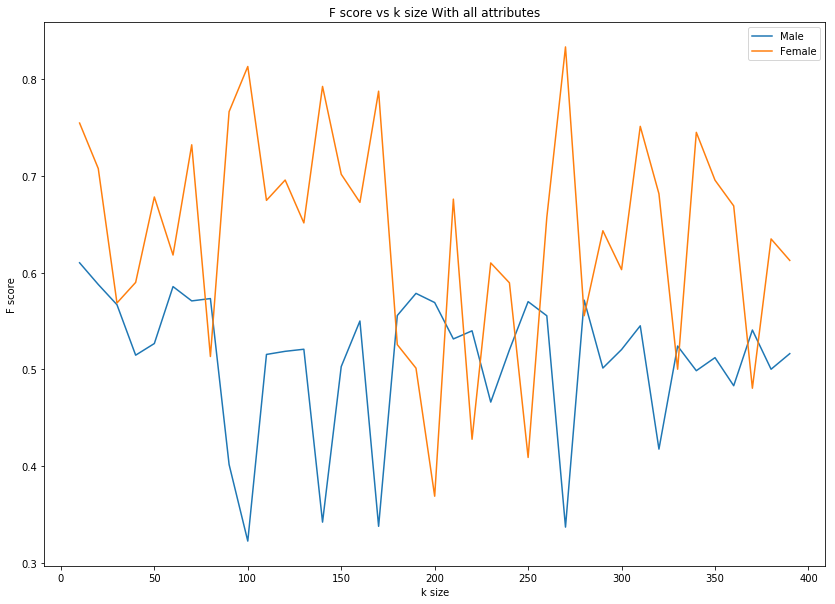

In [7]:
import seaborn as sns
plt.figure(figsize=(14,10))
mLine = sns.lineplot(y=mfscore, x=k)
mLine.set_title('F score vs k size With all attributes')
mLine.set_ylabel('F score')
mLine.set_xlabel('k size')
mLine.set_label('Male F Score')
mLine.plot()

fLine = sns.lineplot(y=ffscore, x=k)
fLine.plot()



plt.legend(['Male', 'Female'])

In [8]:
mfscore = []
ffscore = []
k=[]
attsAll = ['education-num', 'hours-per-week']
for i in range (10, 400, 10):
    pred = get_model(df, i, attsAll)
    mfscore.append(pred[0])
    ffscore.append(pred[1])
    k.append(i)

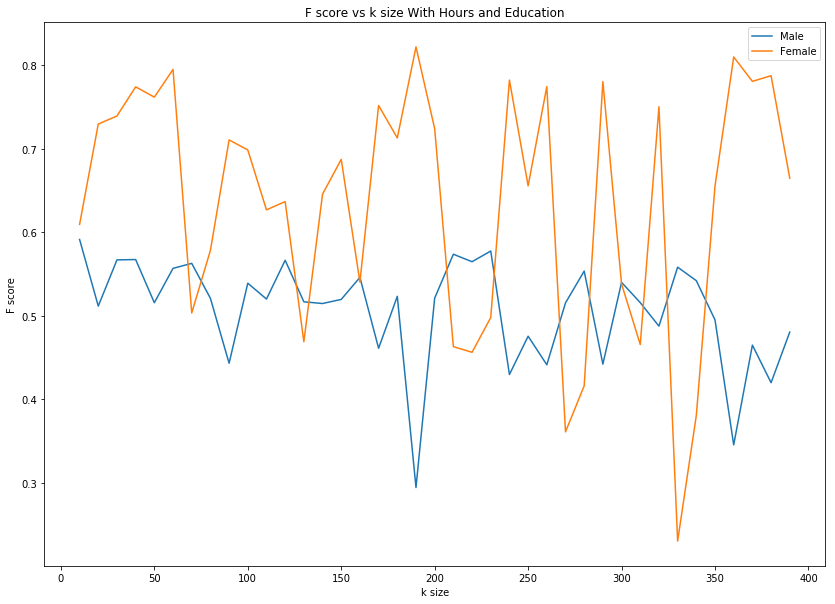

In [9]:
    
plt.figure(figsize=(14,10))
mLine = sns.lineplot(y=mfscore, x=k)
mLine.set_title('F score vs k size With Hours and Education')
mLine.set_ylabel('F score')
mLine.set_xlabel('k size')
mLine.set_label('Male F Score')
mLine.plot()

fLine = sns.lineplot(y=ffscore, x=k)
fLine.plot()



plt.legend(['Male', 'Female'])

In [10]:
mfscore = []
ffscore = []
k=[]
attsAll = ['age', 'hours-per-week']
for i in range (10, 400, 10):
    pred = get_model(df, i, attsAll)
    mfscore.append(pred[0])
    ffscore.append(pred[1])
    k.append(i)

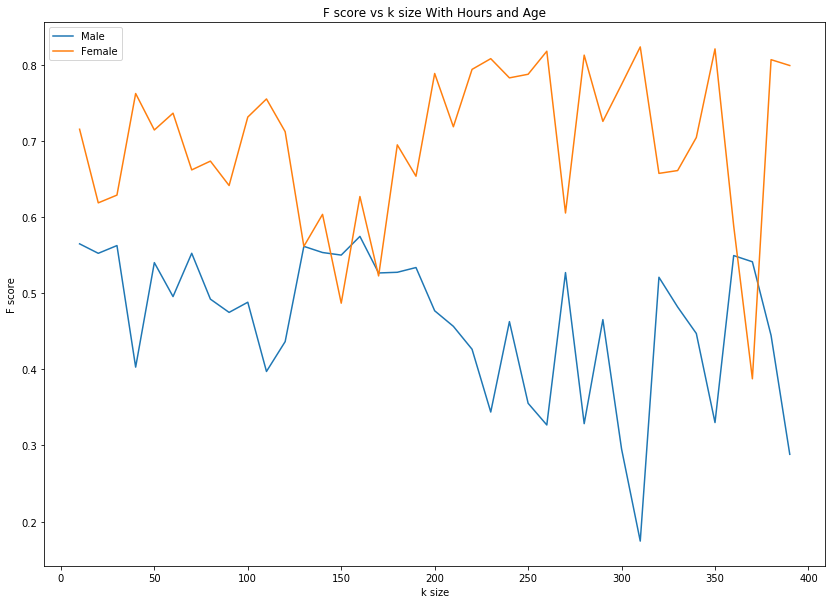

In [11]:

plt.figure(figsize=(14,10))
mLine = sns.lineplot(y=mfscore, x=k)
mLine.set_title('F score vs k size With Hours and Age')
mLine.set_ylabel('F score')
mLine.set_xlabel('k size')
mLine.set_label('Male F Score')
mLine.plot()

fLine = sns.lineplot(y=ffscore, x=k)
fLine.plot()



plt.legend(['Male', 'Female'])

In [13]:
mfscore = []
ffscore = []
k=[]
attsAll = ['hours-per-week']
for i in range (10, 400, 10):
    pred = get_model(df, i, attsAll)
    mfscore.append(pred[0])
    ffscore.append(pred[1])
    k.append(i)

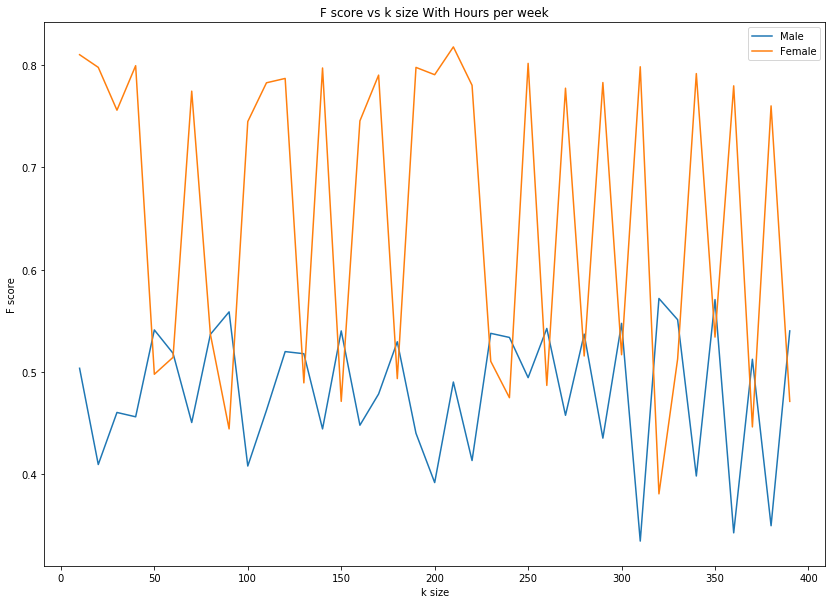

In [14]:

plt.figure(figsize=(14,10))
mLine = sns.lineplot(y=mfscore, x=k)
mLine.set_title('F score vs k size With Hours per week')
mLine.set_ylabel('F score')
mLine.set_xlabel('k size')
mLine.set_label('Male F Score')
mLine.plot()

fLine = sns.lineplot(y=ffscore, x=k)
fLine.plot()



plt.legend(['Male', 'Female'])

In [16]:
def get_modelBig(data, k, atts):
    # X = data[atts].values
    # y = data[['sex']].values
    train, test = train_test_split(data, test_size=0.15, train_size= .15)
    # print(train)
    # print(test)
    trainPred = []
    testPred = []
    for i, T in enumerate(train['sex']):
        # print(i)
        trainPred.append(predict(train[atts].values, train[['sex']].values, train, i, k ))
        
    # print(trainPred)
    (p,r,f,s) = precision_recall_fscore_support(train[['sex']].values, trainPred)
    # print(f)
    return f

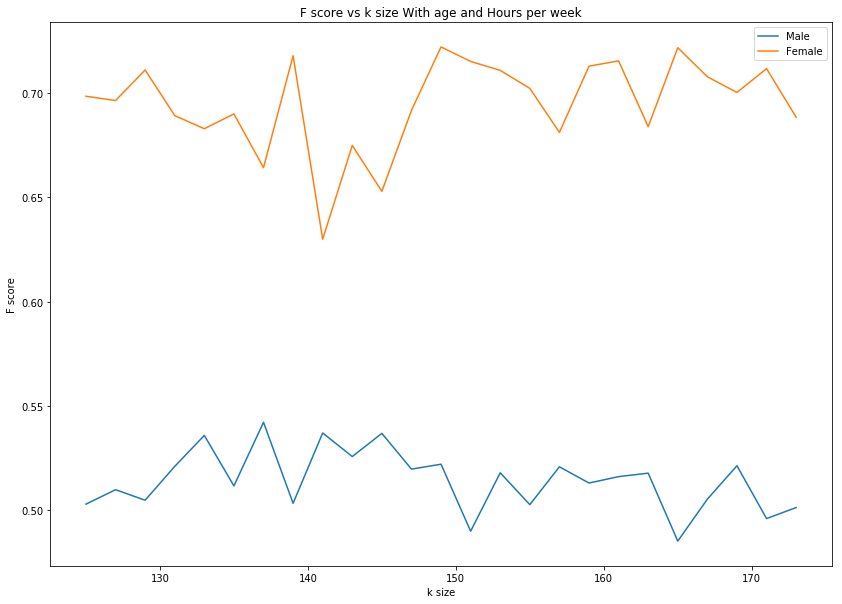

In [17]:
mfscore = []
ffscore = []
k=[]
attsAll = ['age', 'hours-per-week']
for i in range (125, 175, 2):
    pred = get_modelBig(df, i, attsAll)
    mfscore.append(pred[0])
    ffscore.append(pred[1])
    k.append(i)
    
plt.figure(figsize=(14,10))
mLine = sns.lineplot(y=mfscore, x=k)
mLine.set_title('F score vs k size With age and Hours per week')
mLine.set_ylabel('F score')
mLine.set_xlabel('k size')
mLine.set_label('Male F Score')
mLine.plot()

fLine = sns.lineplot(y=ffscore, x=k)
fLine.plot()



plt.legend(['Male', 'Female'])


In [20]:
print(max(mfscore))
print(max(ffscore))

0.5421103581800581
0.7222402071867918


# Curse of dimensionality
"In low-dimensional datasets, the closest points tend to be much closer than average. But two points are close only if they're close in every dimension, and every extra dimension -- even if just noise -- is another opportunity for each point to be further away from every other point. When you have a lot of dimensions it's likely that the closest points aren't much closer than average, which means that two points being close doesn't mean very much (unless there is a *lot* of structure in your data)." -Joel Grus